In [4]:
import numpy as np
import math
# random horizon and simulate the data as it goes
# this function simulate 1 batch of not strictly K numbers of X_n, given fixed Lambda, P, Alpha
# @ param N: is the number of total population
# @ param current_time: a number that is the current time when starting the batch simulation
# @ param x_0: initial infected patients (greater than 0)
# @ param K: is total time for this simulation
# @ param maxi_time: is the maximum time that the whole simulation process can go, can be infinity
# @ param H: is the hospital capacity
def simulation_infected(la, p, al, N, current_time, x_0, K, H, maxTime):
    # initialize time and infected patient
    t_0 = 0
    # bind variables to initial conditions
    x_n = x_0
    # make sure the start is not 0
    assert(x_n!=0)
    # assign time now to 0 first for convenience of bound the simulation size close to K 
    # But in the return statement, add it up to the current time
    t_n = current_time
    # introduce T_H := the total time above the hospital capacity
    T_H = 0
    # initiate X_n process and corresponding T_n process
    X_n = []
    T_n = []
    # k is to keep track of current observation in up tp K(batch size measured by time)
    k = 0
    # loop
    # break condition
    # @ condition1: when the time exceeds the maximum time
    # @ condition2: when the infected patients go to zero
    # @ condition3: when the whole populations are infected! :(
    while (t_n<maxTime and
           x_n != 0 and
           x_n < N and
           k < K
          ):
        i = x_n
        # q i _ i+1
        q_forward_i = la*p*2*x_n*(N-i)/(N*(N-1))
        # q i _ i-1
        q_backward_i = al*i
        # waiting time rate v_i = (q i _ i+1) + (q i _ i-1)
        v_i = q_forward_i + q_backward_i
        t_i = np.random.exponential(v_i)
        # calculate T_H before jumping
        if (x_n >= H):
            T_H += t_i
        # jumping probability to STATE i+1 is (q i _ i+1)/v_i
        jump = np.random.binomial(n=1,p=(q_forward_i/v_i))
        if (jump ==1):
            x_n += 1
        elif (jump == 0):
            x_n -= 1            
        # add the jumped X_n at t_i time
        X_n.append(x_n)
        # increase time
        T_n.append(t_n+t_i)
        t_n = t_n+t_i
        # return when the total time for this batch simulation exceeds K
        # as such, the batch is not strictly equal to K ? might need to discuss
        if ((t_n-current_time) > K):
            return X_n, T_n, T_H,t_n-current_time
    # return when the while break condition met    
    return X_n, T_n, T_H, t_n-current_time

In [8]:
x_n, _lambda,_alpha,p, K, H, Beta, N, maxTime = (10,
                                                    0.1,
                                                    1e-8,
                                                    0.9,
                                                    5,
                                                    2e4,
                                                    0.05,
                                                    4e6,
                                                    30000)

X_n, T_n, T_H, T = simulation_infected(_lambda,p,_alpha,N,0,x_n,K,H,maxTime)

In [25]:
# Y_n() function take the following parameters and return the estimator for L(\theta) - beta
# @ C is the hospital capacity
# @ Beta is the target tracking probability
# def Y_n(T_H,T,Beta):
#     overCapacityCount = 0
#     # K here is the actual batch size, it might vary dependent on simulation
#     K = len(X_n)
#     for i in range(K):
#         if X_n[i] > C:
#             overCapacityCount+=1
#     Y_n = (overCapacityCount/K) - Beta
#     return Y_n
    
def update_lambda(_lambda, T_H, T, stepsize):
    Y_n = T_H/T
    _lambda -= float(stepsize) * Y_n
    return _lambda

def update_alpha(_alpha, T_H, T, stepsize):
    Y_n = T_H/T
    _alpha += float(stepsize) * Y_n
    return _alpha

# @ x_n initial infected patient
# set initial lambda
# set inital alpha
# @ C is the hospital capacity 
# @ Beta is the target tracking probability 
# @ K is the batch size of each estimate
# these are all set arbitary atm
x_n, _lambda,_alpha,p, K, H, Beta, N, maxTime = (10,
                                                    0.1,
                                                    1e-8,
                                                    0.9,
                                                    5,
                                                    2e4,
                                                    0.05,
                                                    4e6,
                                                    30000)

stepsize = [0.01, 2e-9]


trajectory_lambda = []
trajectory_alpha = []
trajectory_X_n = []
trajectory_T_n = []
# use iteration of 5000 as end of all sequential update
iteration = 0
t_n = 0
while iteration < 50000:
    # update alpha
    X_n, T_n, T_H, T = simulation_infected(_lambda,p,_alpha,N,t_n,x_n,K,H,maxTime)
#     print(_alpha)
    print(X_n)
    print("###############")
    _alpha = max(0,update_alpha(_alpha,T_H,T,stepsize[1]))
    trajectory_alpha.append(_alpha)
    trajectory_X_n.extend(X_n)
    trajectory_T_n.extend(T_n)
    
    # to keep the time consistent, slice the tail of last number of infected
    # as the new initial
    x_n = X_n[-1]
    t_n = T_n[-1]
    
    # tn is the re-asigned value from update alpha simulation
    # update lambda
    X_n, T_n, T_H, T = simulation_infected(_lambda,p,_alpha,N,t_n,x_n,K,H,maxTime)
#     print("***************")
#     print(X_n)
    _lambda = max(0, update_lambda(_lambda,T_H, T,stepsize[0]))
    
    trajectory_lambda.append(_lambda)
    trajectory_X_n.extend(X_n)
    trajectory_T_n.extend(T_n)
    
    x_n = X_n[-1]
    t_n = T_n[-1]
    
    iteration+=1
    

[11, 10, 11, 12, 13, 14, 13, 14, 13, 12, 13, 14, 15, 14, 15, 14, 15, 16, 17, 16, 17, 18, 19, 20, 21, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 32, 33, 34, 35, 34, 35, 34, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 44, 45, 46, 47, 46, 47, 48, 49, 50, 51, 52, 51, 52, 53, 54, 55, 56, 57, 58, 57, 58, 59, 60, 61, 62, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 71, 72, 71, 72, 73, 74, 75, 76, 77, 78, 79, 78, 79, 80, 81, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 88, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 96, 97, 98, 99, 100, 101, 102, 103, 104, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 115, 116, 117, 118, 117, 116, 117, 118, 119, 120, 121, 122, 123, 122, 123, 124, 125, 126, 127, 128, 127, 128, 129, 130, 131, 132, 131, 132, 133, 134, 133, 134, 135, 136, 137, 138, 139, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 146, 145, 146, 147, 148, 149, 148, 149, 150, 151, 152, 153, 154, 155, 156, 155, 156, 157, 158, 157, 158, 159, 160, 161, 1

[21557, 21558, 21559, 21560, 21559, 21560, 21561, 21562, 21563, 21564, 21565, 21566, 21567, 21566, 21567, 21568, 21569, 21570, 21571, 21572, 21573, 21574, 21575, 21576, 21575, 21576, 21577, 21578, 21579, 21580, 21581, 21580, 21581, 21582, 21583, 21582, 21583, 21584, 21585, 21586, 21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595, 21596, 21597, 21598, 21599, 21600, 21601, 21602, 21601, 21602, 21603, 21604, 21603, 21604, 21605, 21606, 21607, 21608, 21609, 21610, 21611, 21612, 21613, 21612, 21613, 21614, 21615, 21616, 21617, 21616, 21617, 21616, 21617, 21618, 21619, 21620, 21619, 21620, 21621, 21622, 21623, 21622, 21623, 21624, 21623, 21624, 21625, 21626, 21627, 21628, 21629, 21628, 21629, 21628, 21629, 21628, 21629, 21630, 21631, 21632, 21633, 21634, 21635, 21636, 21637, 21638, 21639, 21638, 21639, 21640, 21641, 21642, 21643, 21644, 21645, 21646, 21647, 21648, 21649, 21650, 21651, 21652, 21653, 21654, 21655, 21656, 21655, 21656, 21657, 21658, 21657, 21658, 21659, 21658, 21659

[33843, 33844, 33843, 33844, 33845, 33846, 33847, 33846, 33845, 33844, 33845, 33846, 33847, 33848, 33849, 33848, 33849, 33848, 33849, 33850, 33851, 33852, 33853, 33852, 33853, 33854, 33853, 33854, 33853, 33854, 33855, 33856, 33855, 33856, 33855, 33856, 33855, 33856, 33855, 33856, 33857, 33856, 33855, 33854, 33853, 33852, 33853, 33852, 33851, 33852, 33851, 33850, 33849, 33850, 33849, 33850, 33851, 33852, 33853, 33852, 33853, 33854, 33855, 33856, 33857, 33858, 33859, 33858, 33859, 33858, 33859, 33858, 33859, 33860, 33859, 33858, 33857, 33858, 33857, 33858, 33859, 33860, 33861, 33860, 33861, 33860, 33861, 33862, 33863, 33864, 33863, 33864, 33863, 33864, 33865, 33866, 33867, 33866, 33865, 33866, 33867, 33866, 33867, 33866, 33865, 33866, 33867, 33868, 33869, 33870, 33869, 33870, 33869, 33870, 33869, 33868, 33867, 33866, 33867, 33868, 33869, 33868, 33869, 33868, 33869, 33870, 33871, 33870, 33869, 33870, 33871, 33872, 33873, 33874, 33873, 33874, 33873, 33872, 33873, 33872, 33871, 33870, 33871

[29787, 29786, 29785, 29784, 29783, 29782, 29781, 29780, 29781, 29780, 29779, 29778, 29777, 29776, 29775, 29774, 29775, 29774, 29773, 29772, 29773, 29772, 29771, 29770, 29769, 29770, 29769, 29770, 29771, 29772, 29771, 29772, 29771, 29770, 29771, 29770, 29769, 29768, 29769, 29770, 29769, 29770, 29769, 29768, 29767, 29766, 29767, 29768, 29767, 29766, 29765, 29766, 29765, 29764, 29763, 29762, 29761, 29760, 29759, 29758, 29757, 29758, 29759, 29758, 29757, 29758, 29757, 29756, 29755, 29754, 29753, 29752, 29751, 29750, 29749, 29748, 29749, 29748, 29747, 29746, 29747, 29746, 29745, 29744, 29743, 29742, 29741, 29740, 29739, 29738, 29737, 29738, 29739, 29738, 29737, 29738, 29737, 29736, 29735, 29734, 29733, 29732, 29731, 29732, 29731, 29730, 29729, 29728, 29727, 29726, 29725, 29726, 29725, 29724, 29723, 29722, 29721, 29720, 29721, 29720, 29719, 29718, 29717, 29718, 29717, 29716, 29715, 29716, 29717, 29716, 29717, 29716, 29715, 29714, 29713, 29712, 29711, 29712, 29711, 29712, 29713, 29712, 29711

AssertionError: 

In [26]:
import matplotlib.pyplot as plt

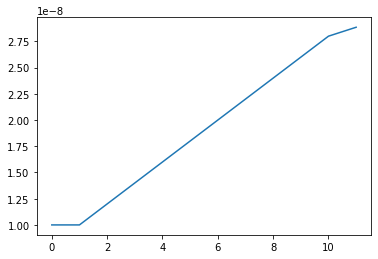

In [28]:
plt.plot(trajectory_alpha)

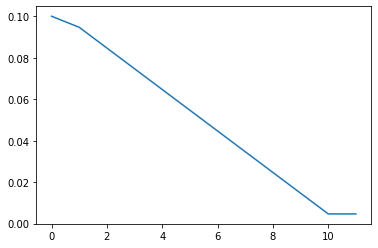

In [29]:
plt.plot(trajectory_lambda)

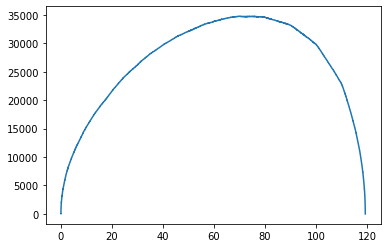

In [30]:
plt.plot(trajectory_T_n,trajectory_X_n)